# RMSProp

## Definition: RMSProp (Root Mean Square Propagation)

RMSProp (Hinton, 2012) adapts the learning rate per parameter using an
exponential moving average of squared gradients, essentially a heuristic,
exponentially weighted version of AdaGrad. Unlike AdaGrad, it is not derived
from a convex optimization objective; it was introduced empirically to
stabilize deep-network training (especially RNNs) by adapting step sizes
without letting them decay to zero. The running average of squared gradients
serves as a measure of how “safe” each direction is: directions with large or
unstable slopes receive smaller steps to avoid overshooting, while flatter
directions receive larger ones.

Because this rescaling partially normalizes each gradient coordinate, RMSProp
often moves in a direction that resembles the sign pattern of the gradient more
than its exact magnitudes. In high-dimensional settings this is not a flaw,
since the sign, that is the octant of the gradient, captures most of the useful
directional information. This type of octant selection can be surprisingly
effective, and sometimes even preferable, under noisy gradients.

Given the gradient at step $t$:
$$
g_t = \nabla_\theta L(\theta_t),
$$

RMSProp keeps an exponential moving average of the component-wise squared
gradients:
$$
s_{t+1} = \alpha\, s_t + (1 - \alpha)\, g_t^2, \qquad s_0 = 0_{\mathbb{R}^{d_\theta}},
$$
where $d_\theta$ denotes the parameter dimension and $\alpha \in [0,1)$ is
the decay rate (common values: $0.9$ or $0.99$).

The parameter update is:
$$
\theta_{t+1} = \theta_t - \eta\, \frac{g_t}{\sqrt{s_{t+1}} + \varepsilon},
$$

where  
• $\eta$ is the learning rate,  
• $\varepsilon > 0$ is a small constant used for numerical stability.

### Property: Exponential Forgetting (Geometric Weighting)
$$
s_{n+1} = (1-\alpha)\sum_{k=0}^{n}
      \alpha^{\,n-k} g_k^2.
$$

Thus, the contribution of a past gradient $g_k^2$ to $s_t$ is
$$
(1-\alpha)\,\alpha^{\,t-1-k},
$$
which decays geometrically with age.

**Proof:** Let's prove it by induction on $n$. 

For $n=1$, we have $s_{1}=(1-\alpha)g^2_0$ on the left side, and on the right side we have 
$$(1-\alpha)\sum_{k=0}^0\alpha^{1-1-k}g^2_{k}=(1-\alpha)\alpha^{0}g^2_{0}=(1-\alpha)g^2_{0},$$
so the equality is true for $n=1$.

Let's prove the induction step, assume the equation is true for $n$, then we have

$$
\begin{align*}
s_{n+1} &= \alpha s_{n} + (1-\alpha)g^2_{n},\\
&=\alpha (1-\alpha)\sum_{k=0}^{n-1}
      \alpha^{n-1-k} g_k^2+ (1-\alpha)g^2_{n},\\
&=(1-\alpha)\sum_{k=0}^{n-1}
      \alpha^{n-k} g_k^2+ (1-\alpha)g^2_{n},\\
&=(1-\alpha)\left(\sum_{k=0}^{n-1}
      \alpha^{n-k} g_k^2+g^2_{n}\right),\\
&=(1-\alpha)\sum_{k=0}^{n}
      \alpha^{n-k} g_k^2.
\end{align*}
$$
so it is also true for $n+1$ and the inducion is completed.

## Code: RMSProp

In [1]:
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from torch.optim.optimizer import Optimizer

from model.mlp import MLP### Training loop

In [2]:
class RMSProp(Optimizer):
    def __init__(self,  params, lr=1e-3, alpha=0.99, eps=1e-8,
                 weight_decay=0.0, momentum=0.0):
        defaults = {
            "lr": lr,
            "eps": eps,
            "alpha": alpha,
            "weight_decay": weight_decay,
            "momentum": momentum,
        }
        # Parent class creates param_groups and self.state
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self):
        """Performs a single AdaGrad update step."""
        for group in self.param_groups:
            lr = group["lr"]
            alpha = group["alpha"]
            eps = group["eps"]
            weight_decay = group["weight_decay"]
            momentum = group["momentum"]

            for p in group["params"]:
                grad = p.grad
                if grad is None:
                    continue

                # Optional L2 weight decay: grad <- grad + λ θ
                if weight_decay != 0.0:
                    grad = grad.add(p, alpha=weight_decay)

                # Initialize state for accumulator parameter s_0 = 0
                state = self.state[p]
                if "square_avg" not in state:
                    state["square_avg"] = torch.zeros_like(p)
                s = state["square_avg"]
                
                # Exponential moving average of squared gradients: s_t
                # s_{t+1} = α s_t + (1 - α) g_t^2  (elementwise)
                s.mul_(alpha).addcmul_(grad, grad, value=1 - alpha)

                # Denominator: sqrt(s_{t+1}) + eps
                denom = s.sqrt().add_(eps)

                if momentum > 0.0:
                    # Initialize state for accumulator parameter v_0 = 0
                    if "velocity" not in state:
                        state["velocity"] = torch.zeros_like(p)
                    v = state["velocity"]
                    # With momentum: v_{t+1} = μ v_t + g_t / denom
                    v.mul_(momentum).addcdiv_(grad, denom)
                    # θ <- θ - lr * v_{t+1}
                    p.add_(v, alpha=-lr)
                else:
                    # Plain RMSProp: θ <- θ - lr * g_t / denom
                    p.addcdiv_(grad, denom, value=-lr)

### Data

In [3]:
def f(x):
    return 1+2*x**2

N = 20
xs = (4*torch.rand(N)-2).unsqueeze(1)
ys = f(xs) + 0.5*torch.randn(N).unsqueeze(1)

x = torch.linspace(-2,2,100,requires_grad=True)
x_eval = torch.linspace(-2,2,100)
torch.manual_seed(1)

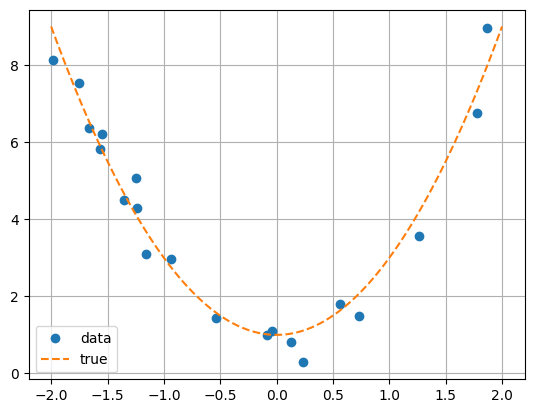

In [5]:
plt.plot(xs.detach().numpy(), ys.detach().numpy(), 'o',label='data')
plt.plot(x.detach().numpy(), f(x).detach().numpy(), '--',label='true')
plt.legend()
plt.grid()
plt.show()


### Training loop

In [6]:
def train(model, opt, loss_fn, data, epochs=20, batch_size=1):
    xs, ys = data
    N = xs.shape[0]
    model.train()
    losses = []
    for epoch in range(epochs):
        perm = torch.randperm(N)  # shuffle for stochasticity each epoch
        for i in range(0, N, batch_size):
            batch_idx = perm[i:i + batch_size]
            x = xs[batch_idx]
            y = ys[batch_idx]
            opt.zero_grad()
            pred = model(x)
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
        losses.append(loss.item())
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")   
    return losses

def compare_losses(loss,nn_loss,title):
    plt.plot(nn_loss,linestyle="-",label="nn_loss")
    plt.plot(loss,linestyle="--",label="loss")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

## Parameters

In [7]:
lr = 0.001
momentum = 0.9
dampening = 0.0
weight_decay= 0.001
nesterov = False

loss_fn = nn.MSELoss()  

### pytorch

In [9]:
torch.manual_seed(1)
model = MLP(input_dim=1,output_dim=1,hidden_dims=[512,512,512],activation=nn.Tanh())
opt = torch.optim.RMSprop(model.parameters(),
          lr=lr,
          weight_decay=weight_decay,
)

nn_loss = train(model,opt,loss_fn,(xs,ys),epochs=150,batch_size=N)

Epoch 1/150, Loss: 23.1352
Epoch 2/150, Loss: 18.2004
Epoch 3/150, Loss: 123.6321
Epoch 4/150, Loss: 24.7679
Epoch 5/150, Loss: 10.1528
Epoch 6/150, Loss: 7.6377
Epoch 7/150, Loss: 6.6567
Epoch 8/150, Loss: 6.0626
Epoch 9/150, Loss: 5.6340
Epoch 10/150, Loss: 5.1694
Epoch 11/150, Loss: 4.7829
Epoch 12/150, Loss: 4.4093
Epoch 13/150, Loss: 4.0900
Epoch 14/150, Loss: 3.7924
Epoch 15/150, Loss: 3.5186
Epoch 16/150, Loss: 3.2908
Epoch 17/150, Loss: 3.2212
Epoch 18/150, Loss: 2.8661
Epoch 19/150, Loss: 2.7928
Epoch 20/150, Loss: 2.5807
Epoch 21/150, Loss: 2.7636
Epoch 22/150, Loss: 2.2310
Epoch 23/150, Loss: 2.0780
Epoch 24/150, Loss: 2.1302
Epoch 25/150, Loss: 2.0658
Epoch 26/150, Loss: 2.6166
Epoch 27/150, Loss: 2.0164
Epoch 28/150, Loss: 1.6232
Epoch 29/150, Loss: 1.4893
Epoch 30/150, Loss: 1.3924
Epoch 31/150, Loss: 1.3502
Epoch 32/150, Loss: 1.6054
Epoch 33/150, Loss: 1.8590
Epoch 34/150, Loss: 2.6313
Epoch 35/150, Loss: 1.8514
Epoch 36/150, Loss: 1.3327
Epoch 37/150, Loss: 1.2395
Epoc

### Custom

Epoch 1/150, Loss: 23.1352
Epoch 2/150, Loss: 18.2004
Epoch 3/150, Loss: 123.6321
Epoch 4/150, Loss: 24.7679
Epoch 5/150, Loss: 10.1528
Epoch 6/150, Loss: 7.6377
Epoch 7/150, Loss: 6.6567
Epoch 8/150, Loss: 6.0626
Epoch 9/150, Loss: 5.6340
Epoch 10/150, Loss: 5.1694
Epoch 11/150, Loss: 4.7829
Epoch 12/150, Loss: 4.4093
Epoch 13/150, Loss: 4.0900
Epoch 14/150, Loss: 3.7924
Epoch 15/150, Loss: 3.5186
Epoch 16/150, Loss: 3.2908
Epoch 17/150, Loss: 3.2212
Epoch 18/150, Loss: 2.8661
Epoch 19/150, Loss: 2.7928
Epoch 20/150, Loss: 2.5807
Epoch 21/150, Loss: 2.7636
Epoch 22/150, Loss: 2.2310
Epoch 23/150, Loss: 2.0780
Epoch 24/150, Loss: 2.1302
Epoch 25/150, Loss: 2.0658
Epoch 26/150, Loss: 2.6166
Epoch 27/150, Loss: 2.0164
Epoch 28/150, Loss: 1.6232
Epoch 29/150, Loss: 1.4893
Epoch 30/150, Loss: 1.3924
Epoch 31/150, Loss: 1.3502
Epoch 32/150, Loss: 1.6054
Epoch 33/150, Loss: 1.8590
Epoch 34/150, Loss: 2.6313
Epoch 35/150, Loss: 1.8514
Epoch 36/150, Loss: 1.3327
Epoch 37/150, Loss: 1.2395
Epoc

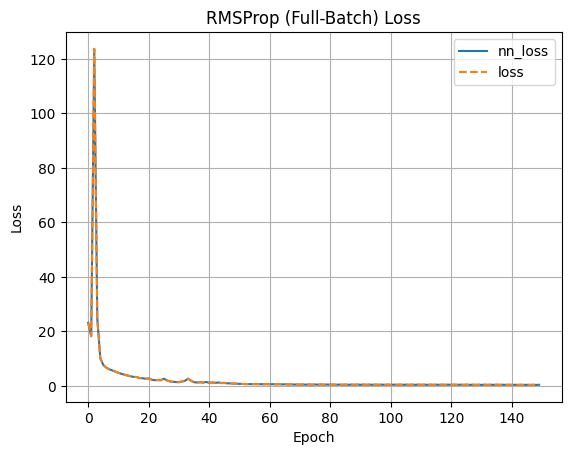

In [11]:
torch.manual_seed(1)
model = MLP(input_dim=1,output_dim=1,hidden_dims=[512,512,512],activation=nn.Tanh())
opt = RMSProp(model.parameters(),
          lr=lr,
          weight_decay=weight_decay,
)

loss = train(model,opt,loss_fn,(xs,ys),epochs=150,batch_size=N)
compare_losses(loss,nn_loss,"RMSProp (Full-Batch) Loss")

# Evaluation

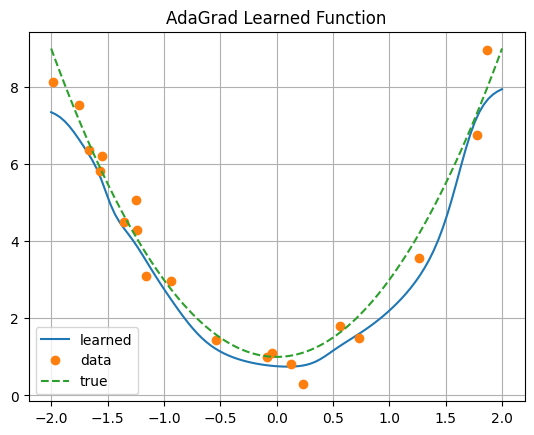

In [ ]:
plt.plot(x_eval,model(x_eval[:,None]).squeeze().detach().numpy(), '-',label='learned')
plt.plot(xs.detach().numpy(), ys.detach().numpy(), 'o',label='data')
plt.plot(x_eval,f(x_eval), '--',label='true')
plt.title("RMSProp Learned Function")
plt.legend()
plt.grid()
plt.show()